In [1]:
library(arrow)
library(tidyverse)


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::duration() masks arrow::duration()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::lag()          masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# Data

In [2]:
schema <- arrow::schema(
  arrow::field("origin_date", arrow::string()),
  arrow::field("scenario_id", arrow::string()),
  arrow::field("location", arrow::string()),
  arrow::field("target", arrow::string()),
  arrow::field("horizon", double()),
  arrow::field("type", arrow::string()),
  arrow::field("type_id", double()),
  arrow::field("model_name", arrow::string()),
  arrow::field("value", double()),
)

In [3]:
##load the data
repo_data <- "../covid19-megaround_data/"
folder_path <- "megaround-processed/"

dc <- arrow::open_dataset(paste0(repo_data, folder_path), partitioning = "model_name", 
                          format = "parquet", schema = schema,
                          factory_options = list(
                            exclude_invalid_files = TRUE))


df_sample <- dplyr::filter(dc, type == "sample" & (target == "inc death" |  target == "inc hosp")) %>% 
  dplyr::collect()


##filter out longer time horizons
df_sample <- df_sample %>% filter(horizon<=104)

##regreate projection date
df_sample <- df_sample %>% mutate(origin_date = lubridate::as_date(origin_date))

In [4]:
###############NOW GET THE MEAN AND STANDARD ERROR OF TOTAL FOR EACH TEAM AND SCENARIO
res_summary <- df_sample %>%
  group_by(scenario_id, model_name, target, location, type_id)%>%
  summarize(tot=sum(value))%>%
  ungroup()%>%
  group_by(scenario_id, model_name, target, location)%>%
  summarize(scn_mn = mean(tot), scn_se=sd(tot)/sqrt(n()))%>%
  ungroup()

## within each level of immune escape.
res_summary <- res_summary %>%
  mutate(imm_escape = ifelse(scenario_id%in%c("A-2023-04-16","C-2023-04-16", "E-2023-04-16"), "Low","High"),
         vax_lvl = ifelse(scenario_id%in%c("A-2023-04-16","B-2023-04-16"), "no boost",
                          ifelse(scenario_id%in%c("C-2023-04-16","D-2023-04-16"),"65+", "all")))

res_summary %>% head()

`summarise()` has grouped output by 'scenario_id', 'model_name', 'target',
'location'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'scenario_id', 'model_name', 'target'. You
can override using the `.groups` argument.


scenario_id,model_name,target,location,scn_mn,scn_se,imm_escape,vax_lvl
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
A-2023-04-16,JHU_IDD-CovidSP,inc death,01,4735.6194,157.04997,Low,no boost
A-2023-04-16,JHU_IDD-CovidSP,inc death,02,409.6049,21.19617,Low,no boost
A-2023-04-16,JHU_IDD-CovidSP,inc death,04,7653.1862,354.19585,Low,no boost
A-2023-04-16,JHU_IDD-CovidSP,inc death,05,2829.6619,114.25434,Low,no boost
A-2023-04-16,JHU_IDD-CovidSP,inc death,06,30137.3913,1466.61206,Low,no boost
A-2023-04-16,JHU_IDD-CovidSP,inc death,08,3854.8870,132.55492,Low,no boost


In [5]:
res_summary %>% filter(model_name==c("JHU_IDD-CovidSP") & imm_escape==c("Low")) %>% 
filter(target==c("inc hosp") & location==c("01"))

scenario_id,model_name,target,location,scn_mn,scn_se,imm_escape,vax_lvl
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
A-2023-04-16,JHU_IDD-CovidSP,inc hosp,01,37702.01,998.6304,Low,no boost
C-2023-04-16,JHU_IDD-CovidSP,inc hosp,01,33092.59,971.7893,Low,65+
E-2023-04-16,JHU_IDD-CovidSP,inc hosp,01,29257.98,882.9091,Low,all


In [6]:
read.csv("data-locations/locations.csv") %>% dplyr::select(abbreviation, location, population) %>%
mutate(location=as.numeric(location)) -> df_loc

merge(res_summary %>% mutate(location=as.numeric(location)), 
      df_loc, by=c("location"), all.x=TRUE) %>% 
  filter(!(abbreviation%in%c("AS", "GU", "MP", "PR", "UM", "VI"))) %>% dplyr::select(-location) -> res_summary_loc

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `location = as.numeric(location)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `location = as.numeric(location)`.
Caused by warning:
! NAs introduced by coercion”


In [7]:
##Pivot wider
res_summary_wide <- res_summary_loc %>% 
  select(-scenario_id) %>%
  pivot_wider(names_from=vax_lvl, values_from = c(scn_mn, scn_se))

In [8]:
se_ratio <- function (mn1, mn2, se1, se2) {
  mn1/mn2 * sqrt((se1/mn1)^2 + (se2/mn2)^2)
}

In [9]:
res_compares <- res_summary_wide %>%
  mutate(no_65plus_mn_diff = `scn_mn_no boost`-`scn_mn_65+`,
         no_65plus_se_diff = sqrt(`scn_se_no boost`^2+`scn_se_65+`^2),
         no_all_mn_diff = `scn_mn_no boost`-`scn_mn_all`,
         no_all_se_diff = sqrt(`scn_se_no boost`^2+`scn_se_all`^2),
         `65plus_all_mn_diff` = `scn_mn_65+`-`scn_mn_all`,
         `65plus_all_se_diff` = sqrt(`scn_se_65+`^2+`scn_se_all`^2),
         no_65plus_mn_rel = `scn_mn_65+`/`scn_mn_no boost`,
         no_65plus_se_rel = se_ratio(`scn_mn_65+`, `scn_mn_no boost`, `scn_se_65+`,`scn_se_no boost`),
         no_all_mn_rel = `scn_mn_all`/`scn_mn_no boost`,
         no_all_se_rel = se_ratio(`scn_mn_all`,`scn_mn_no boost`,  `scn_se_all`, `scn_se_no boost`),
         `65plus_all_mn_rel` = `scn_mn_all`/`scn_mn_65+`,
         `65plus_all_se_rel` = se_ratio(`scn_mn_all`,`scn_mn_65+`,`scn_se_all`, `scn_se_65+`)) %>%
  select(model_name, target, abbreviation, imm_escape,
         no_65plus_mn_diff, no_all_mn_diff,`65plus_all_mn_diff`,
         no_65plus_se_diff, no_all_se_diff,`65plus_all_se_diff`,
         no_65plus_mn_rel, no_all_mn_rel,`65plus_all_mn_rel`,
         no_65plus_se_rel, no_all_se_rel,`65plus_all_se_rel`)

In [10]:
res_compares_lng <-  res_compares %>%
  pivot_longer(cols=c(no_65plus_mn_diff,
                      no_65plus_se_diff,
                      no_all_mn_diff,
                      no_all_se_diff,
                      `65plus_all_mn_diff`,
                      `65plus_all_se_diff`,
                      no_65plus_mn_rel,
                      no_65plus_se_rel,
                      no_all_mn_rel,
                      no_all_se_rel,
                      `65plus_all_mn_rel`,
                      `65plus_all_se_rel`)) %>%
  mutate(measure=ifelse(stringr::str_detect(name,"mn"),"mn","se"),
         diff_rel = ifelse(stringr::str_detect(name,"diff"),"diff","rel"),
         compare=ifelse(stringr::str_detect(name,"no_all"), "None vs All",
                        ifelse(stringr::str_detect(name,"no_65plus"), "None vs 65+", "65+ vs All")),
         target_labs=ifelse(stringr::str_detect(target, "inc death"), "Deaths", "Hospitalizations")) %>%
  select(-name)%>%
  pivot_wider(values_from = value, names_from = measure)

In [11]:
res_compares_lng %>% filter(abbreviation=="US") -> res_compares_lng_US
res_compares_lng %>% filter(abbreviation=="WA") -> res_compares_lng_WA
res_compares_lng %>% filter(abbreviation!="US") -> res_compares_lng

In [12]:
## Gdt the random effect models for each level.
cex_val = 1
refline = 0
outcome_string  = "(Number Averted)"
tgt_vec <- c("Hospitalizations", "Deaths")
state_vec <- unique(res_compares_lng$abbreviation)

In [13]:
values <- list()
meta_res_abs <- tibble()
for(state in state_vec){
    values[[state]] <- list()
    for (imm_esc in c("Low", "High")){
      values[[state]][[imm_esc]] <- list()
      for (comparison in c("None vs 65+","None vs All","65+ vs All")) {
        values[[state]][[imm_esc]][[comparison]] <- list()
        for (tgt in tgt_vec){
          outcome_col_i <- which(tgt_vec == tgt)
          meta <- metafor::rma.uni(yi=mn, sei=se,
                                   data=filter(res_compares_lng , str_detect(target, "inc") &
                                               abbreviation==state & imm_escape==imm_esc &
                                               target_labs==tgt & compare==comparison &
                                               diff_rel=="diff" & mn > 0),
                                   control=list(stepadj=0.5, maxiter=10000))

          values[[state]][[imm_esc]][[comparison]][[tgt]] <- meta
            
          meta_res_abs <- meta_res_abs %>% bind_rows( 
              tibble(comp = comparison, imm_esc = imm_esc, target = tgt, 
                     state = state,
                     mean = as.numeric(meta[["b"]]),
                     lb = meta[["ci.lb"]],
                     ub = meta[["ci.ub"]],
                     se = meta[["se"]],
                     n_ests = length(meta[["yi"]])))
        }
      }
    }
}

merge(meta_res_abs, df_loc %>% rename(state=abbreviation) %>% dplyr::select(state, population), 
      by=c("state"), all.x=TRUE) %>% 
mutate(imm_esc=case_when(imm_esc==c("Low")~c("Low Immune Escape"), 
                         imm_esc==c("High")~c("High Immune Escape"))) -> meta_res_abs

In [14]:
values <- list()
meta_res_abs_national <- tibble()
for (imm_esc in c("Low", "High")){
  values[[state]][[imm_esc]] <- list()
  for (comparison in c("None vs 65+","None vs All","65+ vs All")) {
    values[[state]][[imm_esc]][[comparison]] <- list()
    for (tgt in tgt_vec){
      outcome_col_i <- which(tgt_vec == tgt)
      meta <- metafor::rma.uni(yi=mn, sei=se,
                               data=filter(res_compares_lng_US , str_detect(target, "inc") &
                                           imm_escape==imm_esc & target_labs==tgt & 
                                           compare==comparison & diff_rel=="diff"),
                               control=list(stepadj=0.5, maxiter=10000))

      values[[state]][[imm_esc]][[comparison]][[tgt]] <- meta

      meta_res_abs_national <- meta_res_abs_national %>% bind_rows( 
          tibble(comp = comparison, imm_esc = imm_esc, target = tgt, 
                 state = c("US"),
                 mean = as.numeric(meta[["b"]]),
                 lb = meta[["ci.lb"]],
                 ub = meta[["ci.ub"]],
                 se = meta[["se"]],
                 n_ests = length(meta[["yi"]])))
    }
  }
}

meta_res_abs %>% filter(target==c("Hospitalizations") & 
                        imm_esc==c("Low Immune Escape") & comp==c("None vs All")) -> temp
meta_res_abs_national %>% mutate(population=sum(temp$population)) %>%
mutate(imm_esc=case_when(imm_esc==c("Low")~c("Low Immune Escape"), 
                         imm_esc==c("High")~c("High Immune Escape"))) %>%
mutate(value=mean/population*100000) -> meta_res_abs_national

In [15]:
read.csv("../../../Dropbox/UNC_Flu_Pipeline_2022/vaccine_previous/vacc_alldoses_age_R17.csv") %>% 
filter(dose==c("dose6")) -> booster_df

read.csv("../../../Dropbox/UNC_Flu_Pipeline_2022/vaccine_previous/vacc_alldoses_age_R2_2.csv") -> vac_df

vac_df %>% dplyr::select(USPS, NAME) %>% distinct() -> state_name
merge(booster_df, state_name, by=c("USPS"), all.x=TRUE) %>% filter(!USPS==c("US")) %>%
dplyr::select(NAME, date, age_group, age_l, age_r, USPS, geoid, pop, dose, vacc_age, prop_vacc_age) -> booster_df
booster_df$date <- as.Date(booster_df$date)

booster1_approval_time <- c(as.Date("2023-09-01"), as.Date("2023-09-01"), as.Date("2023-09-01"))
                            
booster_df %<>% filter(date >= as.Date("2023-09-01")) %>%
mutate(t_since=case_when(age_group==c("0_17")~as.numeric(date-booster1_approval_time[1])/30,
                         age_group==c("18_64")~as.numeric(date-booster1_approval_time[2])/30,
                         age_group==c("65_100")~as.numeric(date-booster1_approval_time[3])/30))

Warning message:
“ggrepel: 44 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 47 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 43 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 43 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


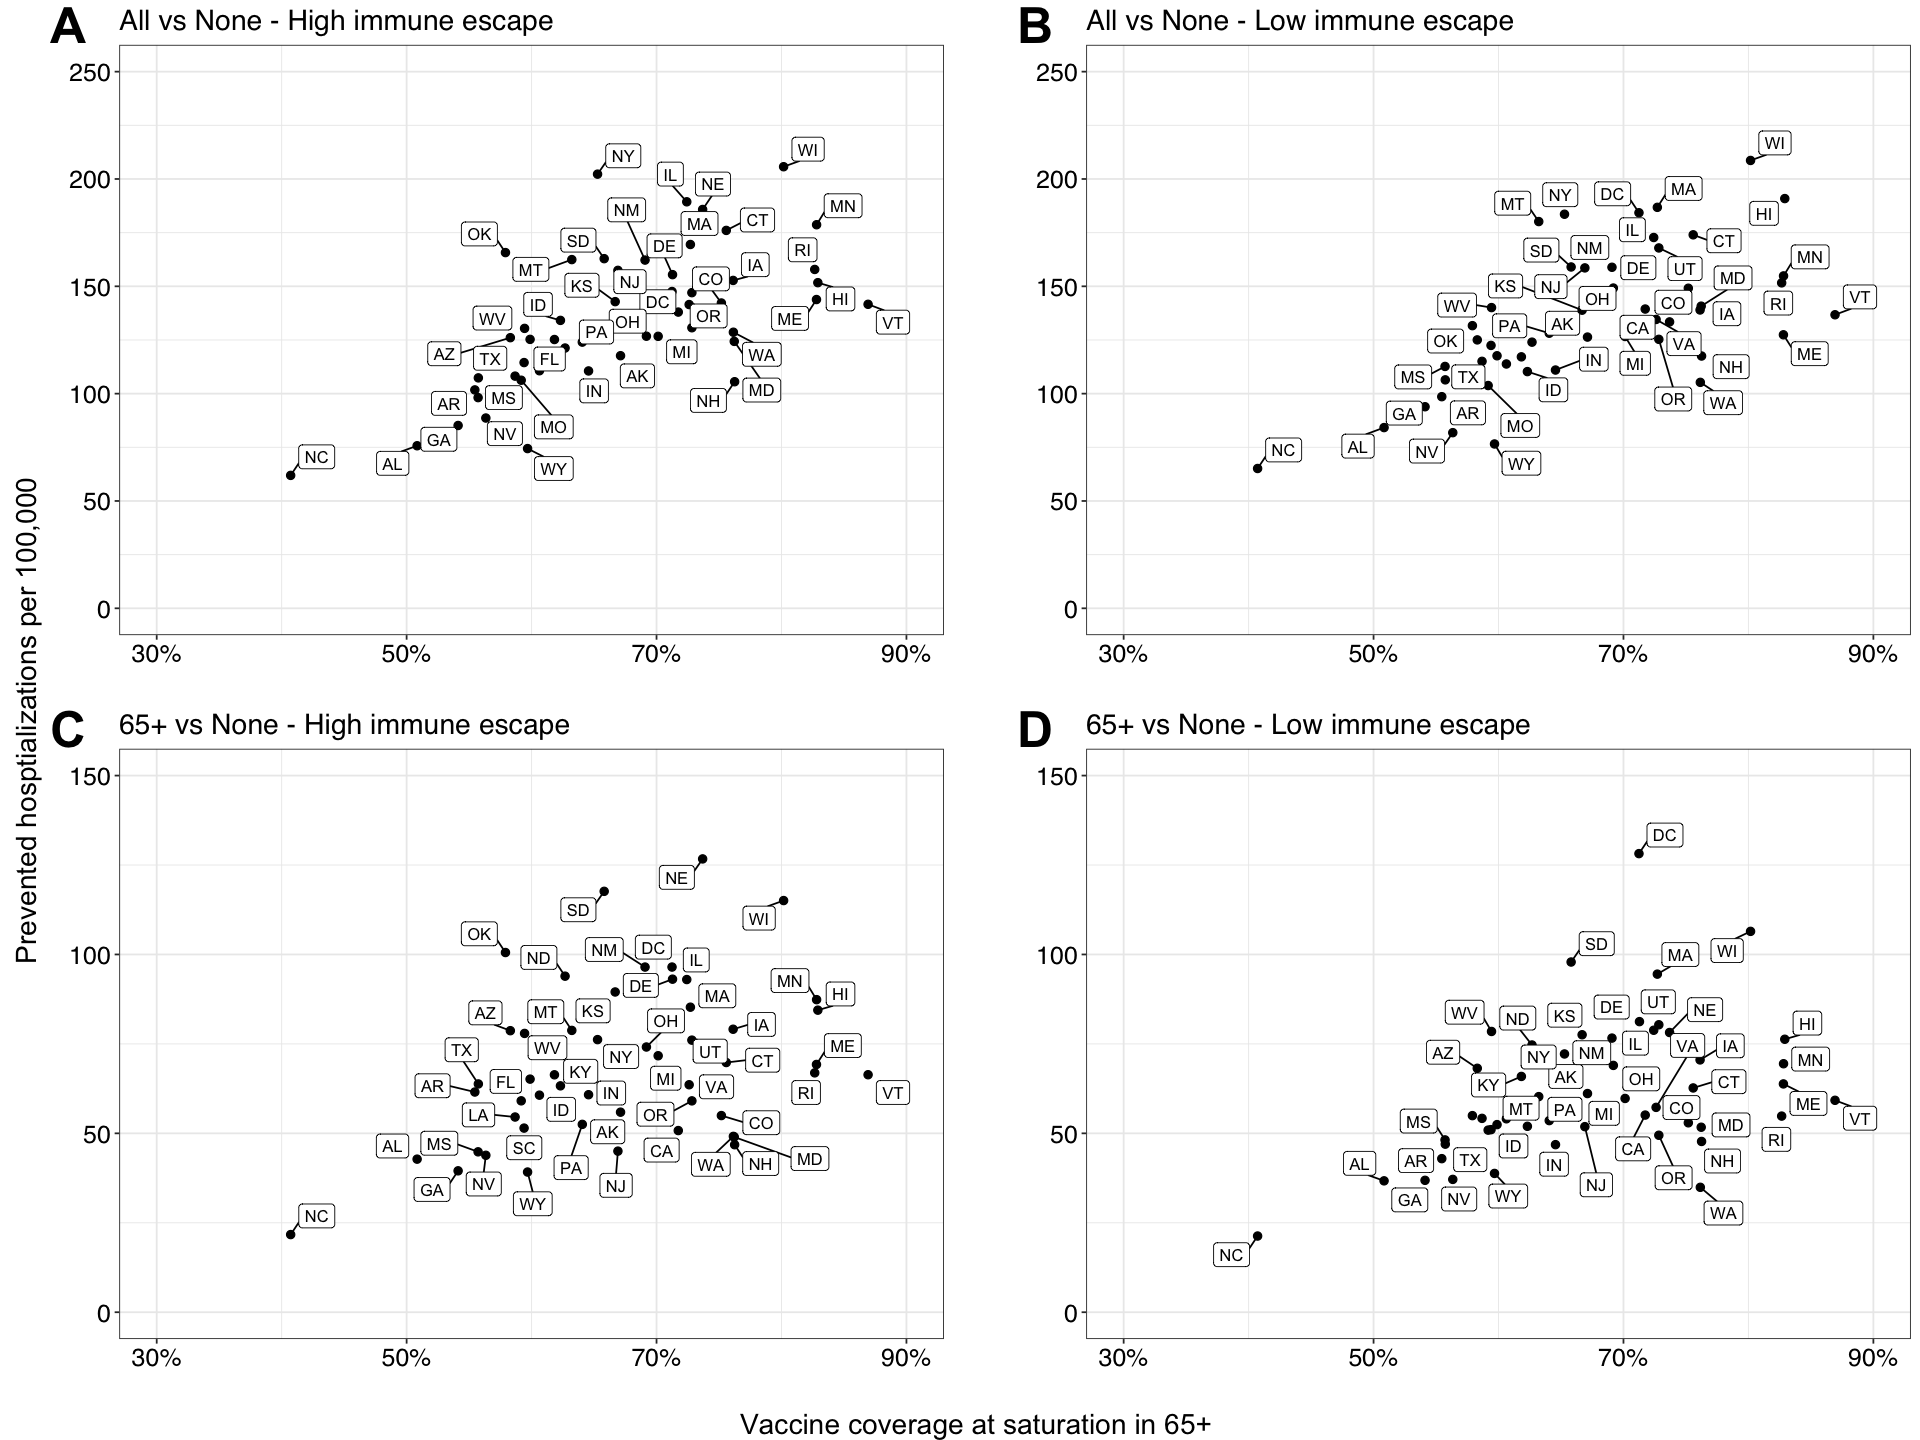

In [16]:
library(ggrepel); library(grid); library(ggpubr)
theme_set(theme_bw())

merge(meta_res_abs %>% 
      filter(target==c("Hospitalizations") & comp==c("None vs All") & imm_esc==c("High Immune Escape")) %>% 
      mutate(var=mean/population*100000), 
      booster_df %>% filter(date==as.Date("2024-09-01") & age_group==c("65_100")) %>% rename(state=USPS) %>%
      dplyr::select(state, prop_vacc_age), by=c("state"), all.x=TRUE) -> scatter_65_100_High_All

merge(meta_res_abs %>% 
      filter(target==c("Hospitalizations") & comp==c("None vs All") & imm_esc==c("Low Immune Escape")) %>% 
      mutate(var=mean/population*100000), 
      booster_df %>% filter(date==as.Date("2024-09-01") & age_group==c("65_100")) %>% rename(state=USPS) %>%
      dplyr::select(state, prop_vacc_age), by=c("state"), all.x=TRUE) -> scatter_65_100_Low_All

merge(meta_res_abs %>% 
      filter(target==c("Hospitalizations") & comp==c("None vs 65+") & imm_esc==c("High Immune Escape")) %>% 
      mutate(var=mean/population*100000), 
      booster_df %>% filter(date==as.Date("2024-09-01") & age_group==c("65_100")) %>% rename(state=USPS) %>%
      dplyr::select(state, prop_vacc_age), by=c("state"), all.x=TRUE) -> scatter_65_100_High_65

merge(meta_res_abs %>% 
      filter(target==c("Hospitalizations") & comp==c("None vs 65+") & imm_esc==c("Low Immune Escape")) %>% 
      mutate(var=mean/population*100000), 
      booster_df %>% filter(date==as.Date("2024-09-01") & age_group==c("65_100")) %>% rename(state=USPS) %>%
      dplyr::select(state, prop_vacc_age), by=c("state"), all.x=TRUE) -> scatter_65_100_Low_65


rownames(scatter_65_100_High_All) <- scatter_65_100_High_All$state
rownames(scatter_65_100_Low_All) <- scatter_65_100_Low_All$state
rownames(scatter_65_100_High_65) <- scatter_65_100_High_65$state
rownames(scatter_65_100_Low_65) <- scatter_65_100_Low_65$state

options(repr.plot.width=8,repr.plot.height=6)
scatter_65_100_High_All %>%
ggplot(aes(x = prop_vacc_age, y = var)) + 
geom_point(size=2) +
geom_label_repel(label=rownames(scatter_65_100_High_All), size=3.5) +
scale_y_continuous(limits=c(0, 250), breaks=c(0, 50, 100, 150, 200, 250))+
scale_x_continuous(limits=c(0.3, 0.9), breaks=c(0.3, 0.5, 0.7, 0.9), labels=c("30%", "50%", "70%", "90%"))+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
labs(x="", y="", title="All vs None - High immune escape") -> hosp_scatter

scatter_65_100_Low_All %>%
ggplot(aes(x = prop_vacc_age, y = var)) + 
geom_point(size=2) +
geom_label_repel(label=rownames(scatter_65_100_High_All), size=3.5) +
scale_y_continuous(limits=c(0, 250), breaks=c(0, 50, 100, 150, 200, 250))+
scale_x_continuous(limits=c(0.3, 0.9), breaks=c(0.3, 0.5, 0.7, 0.9), labels=c("30%", "50%", "70%", "90%"))+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +

labs(x="", y="", title="All vs None - Low immune escape") -> hosp_scatter2

scatter_65_100_High_65 %>%
ggplot(aes(x = prop_vacc_age, y = var)) + 
geom_point(size=2) +
geom_label_repel(label=rownames(scatter_65_100_High_All), size=3.5) +
scale_y_continuous(limits=c(0, 150), breaks=c(0, 50, 100, 150, 200, 250))+
scale_x_continuous(limits=c(0.3, 0.9), breaks=c(0.3, 0.5, 0.7, 0.9), labels=c("30%", "50%", "70%", "90%"))+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
labs(x="", y="", title="65+ vs None - High immune escape") -> hosp_scatter_65

scatter_65_100_Low_65 %>%
ggplot(aes(x = prop_vacc_age, y = var)) + 
geom_point(size=2) +
geom_label_repel(label=rownames(scatter_65_100_High_All), size=3.5) +
scale_y_continuous(limits=c(0, 150), breaks=c(0, 50, 100, 150, 200, 250))+
scale_x_continuous(limits=c(0.3, 0.9), breaks=c(0.3, 0.5, 0.7, 0.9), labels=c("30%", "50%", "70%", "90%"))+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +

labs(x="", y="", title="65+ vs None - Low immune escape") -> hosp_scatter_652

options(repr.plot.width=16,repr.plot.height=12)
ggarrange(hosp_scatter, ggplot() + theme_void(), hosp_scatter2, 
          hosp_scatter_65, ggplot() + theme_void(), hosp_scatter_652, widths = c(1, 0.05, 1, 1, 0.05, 1), 
          labels = c("A", "", "B", "C", "", "D"), font.label = list(size = 30), vjust=1.2,
          ncol = 3, nrow = 2) -> scatter_rel

options(repr.plot.width=16,repr.plot.height=12)
annotate_figure(scatter_rel, 
                left = textGrob("Prevented hosptializations per 100,000", rot = 90, 
                                vjust = 1, gp = gpar(cex = 1.3, fontsize=13)),
                bottom = textGrob("Vaccine coverage at saturation in 65+", 
                                  gp = gpar(cex = 1.3, fontsize=13))) -> scatter_rel

scatter_rel

ggsave("../covid19-scenario-modeling-hub-R17-paper/Figures/Final_figures/Figure3.tiff", 
       scatter_rel, width=16.5, height=12.5, bg="white", dpi=300)

In [17]:
values <- list()
meta_res_abs <- tibble()
for(state in state_vec){
    values[[state]] <- list()
    for (imm_esc in c("Low", "High")){
      values[[state]][[imm_esc]] <- list()
      for (comparison in c("None vs 65+","None vs All","65+ vs All")) {
        values[[state]][[imm_esc]][[comparison]] <- list()
        for (tgt in tgt_vec){
          outcome_col_i <- which(tgt_vec == tgt)
          meta <- metafor::rma.uni(yi=mn, sei=se,
                                   data=filter(res_compares_lng , str_detect(target, "inc") &
                                               abbreviation==state & imm_escape==imm_esc &
                                               target_labs==tgt & compare==comparison &
                                               diff_rel=="rel" & mn > 0),
                                   control=list(stepadj=0.5, maxiter=10000))

          values[[state]][[imm_esc]][[comparison]][[tgt]] <- meta
            
          meta_res_abs <- meta_res_abs %>% bind_rows( 
              tibble(comp = comparison, imm_esc = imm_esc, target = tgt, 
                     state = state,
                     mean = as.numeric(meta[["b"]]),
                     lb = meta[["ci.lb"]],
                     ub = meta[["ci.ub"]],
                     se = meta[["se"]],
                     n_ests = length(meta[["yi"]])))
        }
      }
    }
}

merge(meta_res_abs, df_loc %>% rename(state=abbreviation) %>% dplyr::select(state, population), 
      by=c("state"), all.x=TRUE) %>% 
mutate(imm_esc=case_when(imm_esc==c("Low")~c("Low Immune Escape"), 
                         imm_esc==c("High")~c("High Immune Escape"))) -> meta_res_abs

Warning message:
“Fisher scoring algorithm may have gotten stuck at a local maximum.
Setting tau^2 = 0. Check the profile likelihood plot with profile().”


In [18]:
values <- list()
meta_res_abs_national <- tibble()
for (imm_esc in c("Low", "High")){
  values[[state]][[imm_esc]] <- list()
  for (comparison in c("None vs 65+","None vs All","65+ vs All")) {
    values[[state]][[imm_esc]][[comparison]] <- list()
    for (tgt in tgt_vec){
      outcome_col_i <- which(tgt_vec == tgt)
      meta <- metafor::rma.uni(yi=mn, sei=se,
                               data=filter(res_compares_lng_US , str_detect(target, "inc") &
                                           imm_escape==imm_esc & target_labs==tgt & 
                                           compare==comparison & diff_rel=="rel"),
                               control=list(stepadj=0.5, maxiter=10000))

      values[[state]][[imm_esc]][[comparison]][[tgt]] <- meta

      meta_res_abs_national <- meta_res_abs_national %>% bind_rows( 
          tibble(comp = comparison, imm_esc = imm_esc, target = tgt, 
                 state = c("US"),
                 mean = as.numeric(meta[["b"]]),
                 lb = meta[["ci.lb"]],
                 ub = meta[["ci.ub"]],
                 se = meta[["se"]],
                 n_ests = length(meta[["yi"]])))
    }
  }
}

meta_res_abs %>% filter(target==c("Hospitalizations") & 
                        imm_esc==c("Low Immune Escape") & comp==c("None vs All")) -> temp
meta_res_abs_national %>% mutate(population=sum(temp$population)) %>%
mutate(imm_esc=case_when(imm_esc==c("Low")~c("Low Immune Escape"), 
                         imm_esc==c("High")~c("High Immune Escape"))) %>%
mutate(value=mean/population*100000) -> meta_res_abs_national

In [19]:
library(ggpubfigs)
pal <- friendly_pal("contrast_three", 51, type = "continuous")


Attaching package: ‘ggpubfigs’


The following object is masked from ‘package:ggplot2’:

    theme_grey




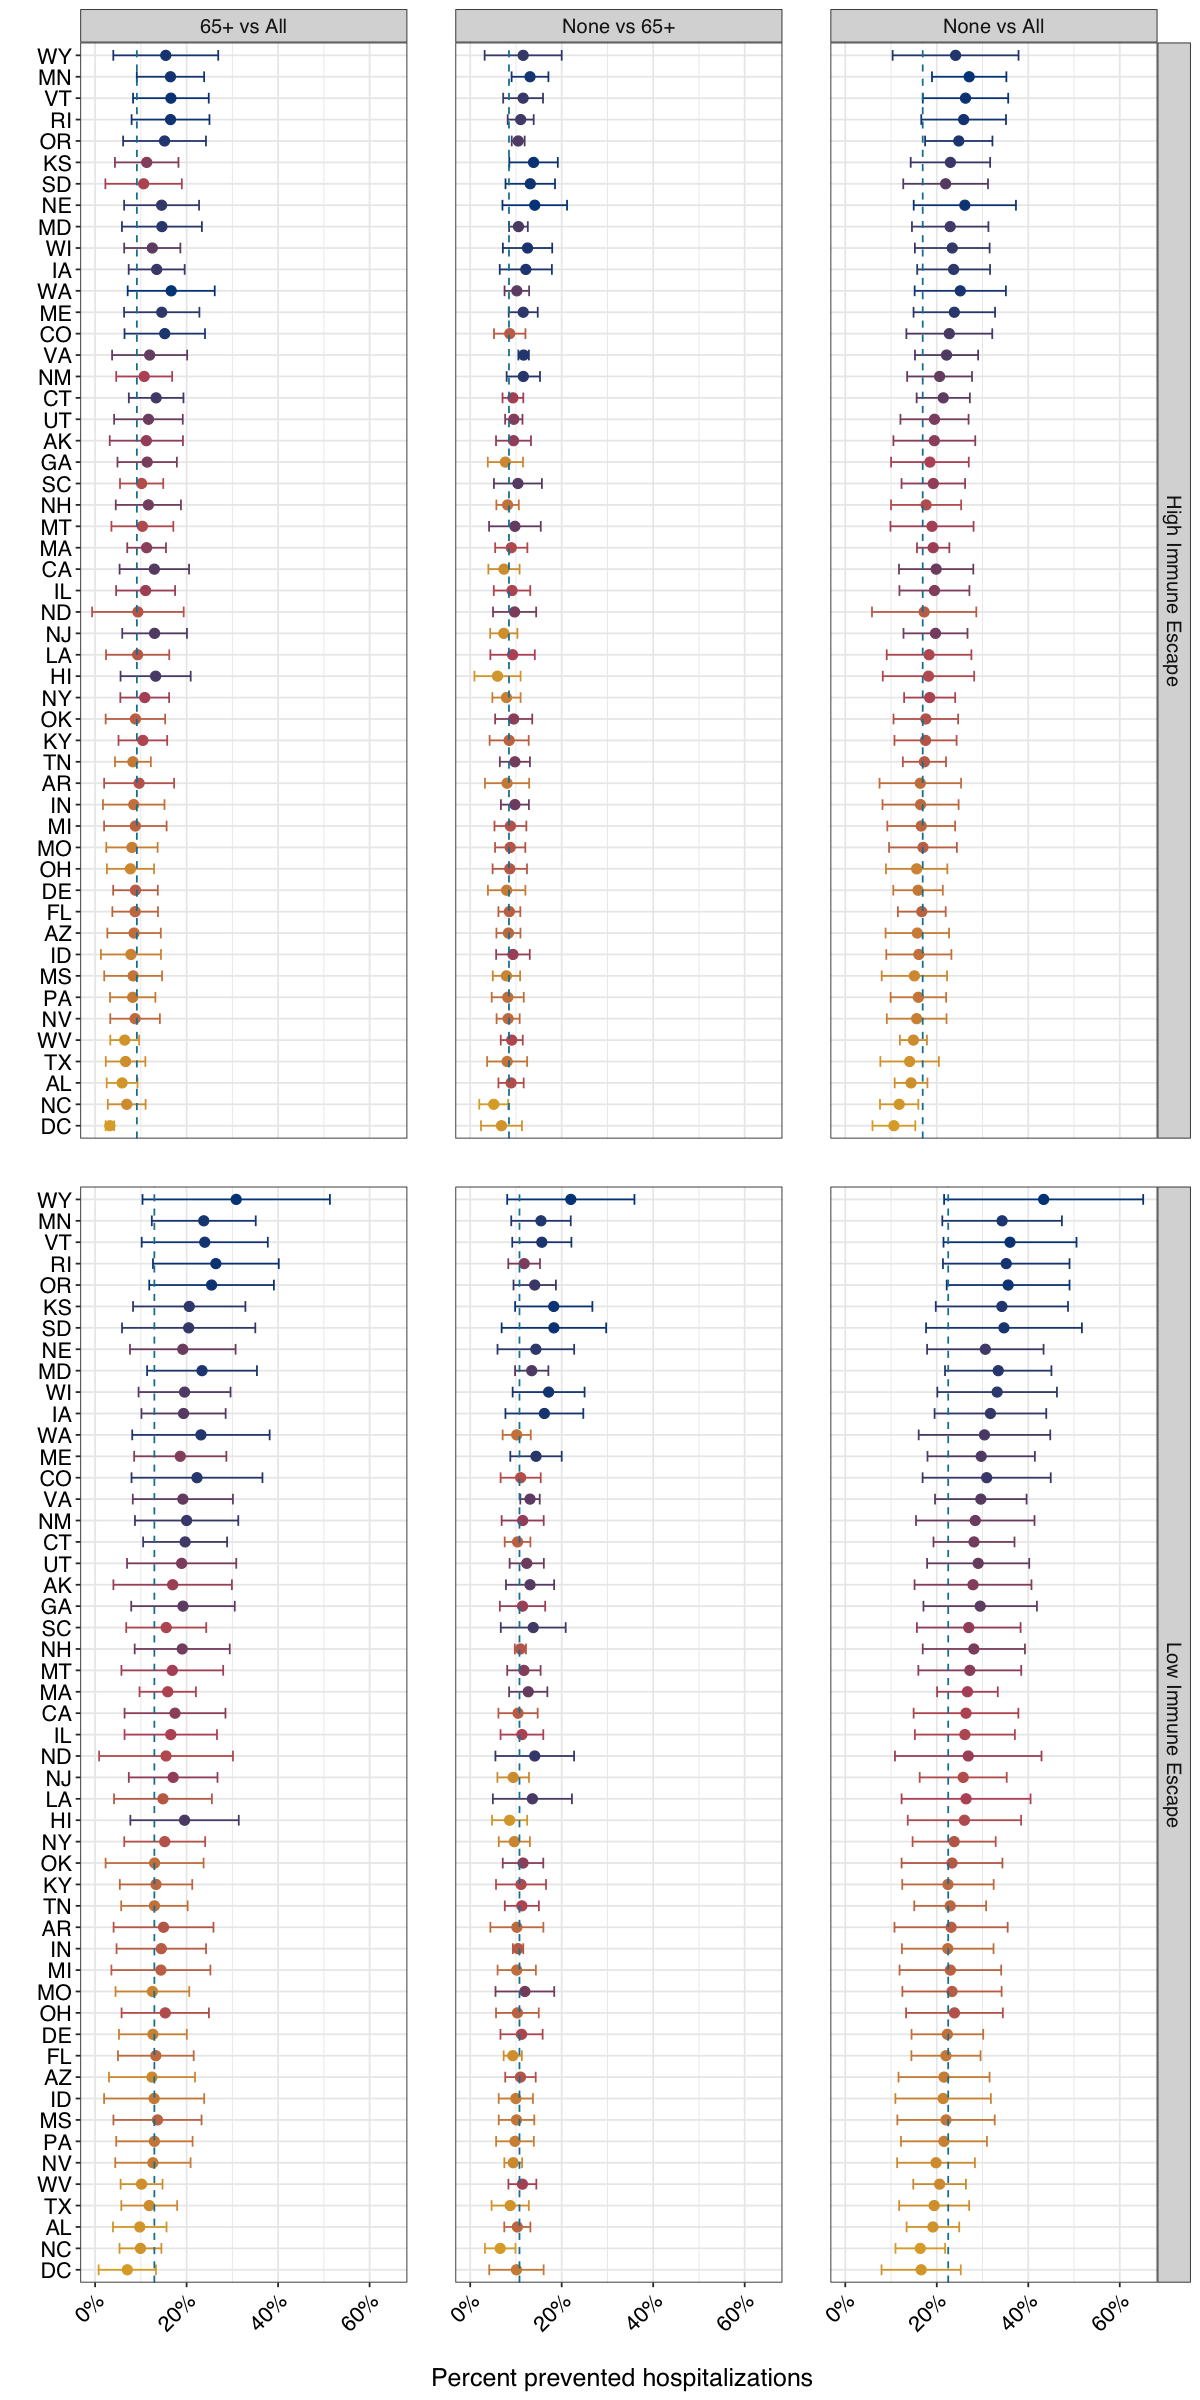

In [20]:
theme_set(theme_bw())
options(repr.plot.width=10,repr.plot.height=20)

meta_res_abs$comp <- factor(meta_res_abs$comp, 
levels = c("None vs All", "None vs 65+", "65+ vs All"))

meta_res_abs %>% filter(target==c("Hospitalizations")) %>% mutate(var=(1-mean)*100) %>%
group_by(imm_esc, comp) %>% arrange(var) %>% mutate(color_order=order(var)) %>% ungroup() %>%
ggplot(aes(x=reorder(state, var), y=(1-mean)*100, color=color_order))+
geom_point(size=2.5) +
geom_errorbar(aes(ymin=(1-ub)*100, ymax=(1-lb)*100), width=.5) +
# scale_color_viridis_c(option = "C", direction=-1) +
scale_color_gradientn(colours=pal, trans = 'reverse')+
scale_y_continuous(breaks=c(0, 20, 40, 60), labels=c("0%", "20%", "40%", "60%"))+
facet_grid(rows=vars(imm_esc), cols=vars(comp))+
geom_hline(data=meta_res_abs_national %>% filter(target==c("Hospitalizations")), 
           aes(yintercept=(1-mean)*100), linetype='dashed', linewidth=0.5, col='#1380A1') +
coord_flip(ylim = c(0, 65)) +
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=13, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1),
      panel.spacing = unit(2, "lines")) +
labs(x="", y="\n Percent prevented hospitalizations") -> state_hosp_vaccine

state_hosp_vaccine
ggsave("../covid19-scenario-modeling-hub-R17-paper/Figures/Final_figures/FigureS4.tiff", 
       state_hosp_vaccine, width=10, height=20, dpi=300)

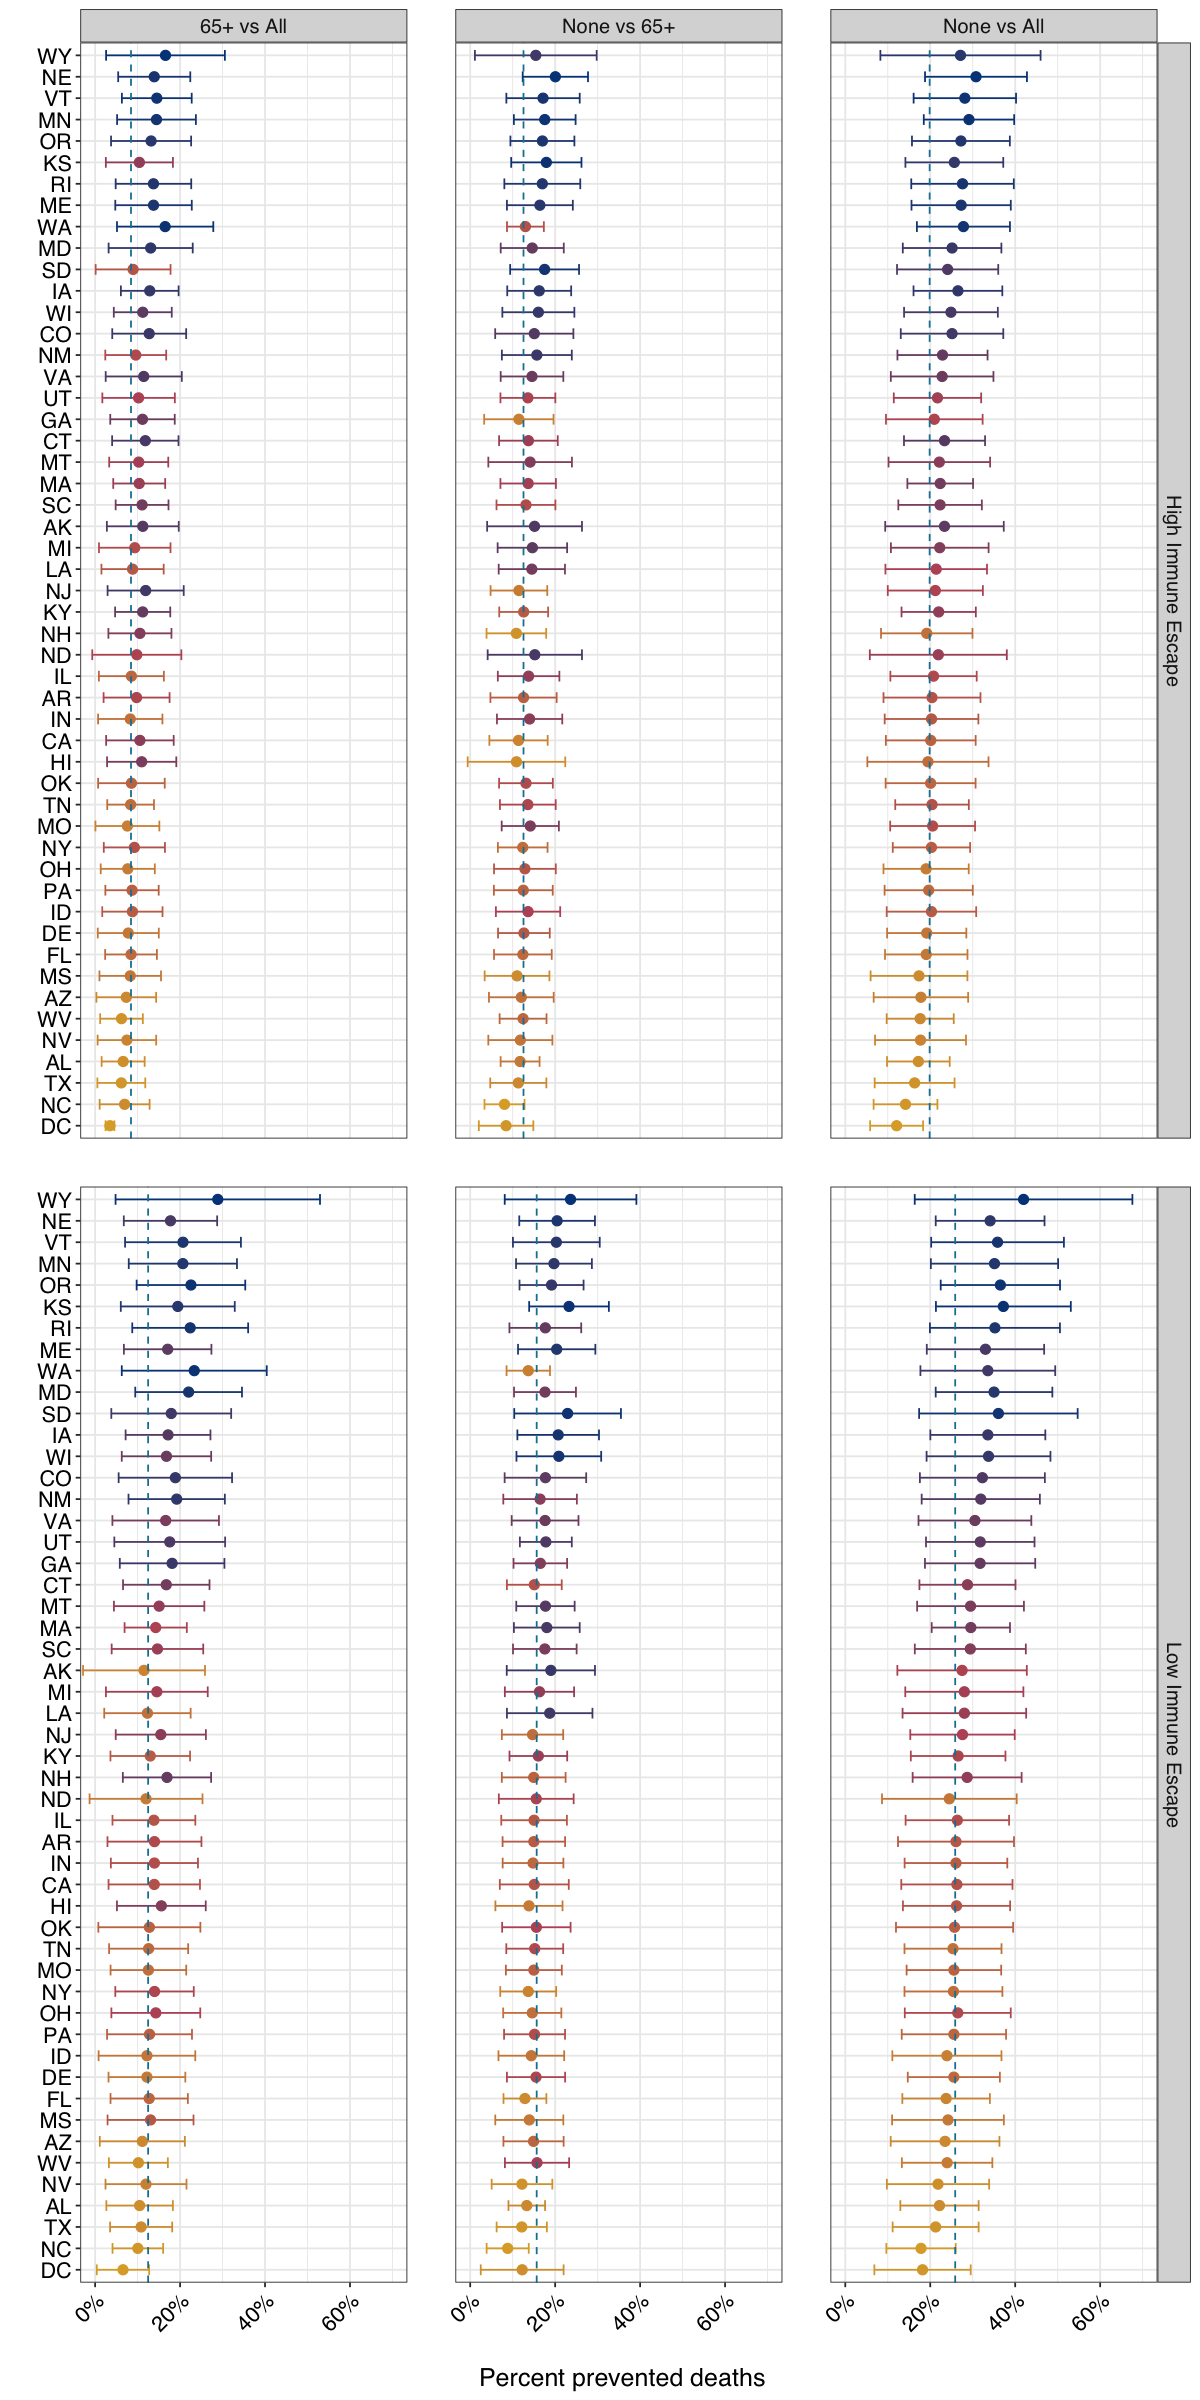

In [21]:
meta_res_abs$comp <- factor(meta_res_abs$comp, 
levels = c("None vs All", "None vs 65+", "65+ vs All"))

meta_res_abs %>% filter(target==c("Deaths")) %>% mutate(var=(1-mean)*100) %>%
group_by(imm_esc, comp) %>% arrange(var) %>% mutate(color_order=order(var)) %>% ungroup() %>%
ggplot(aes(x=reorder(state, var), y=(1-mean)*100, color=color_order))+
geom_point(size=2.5) +
geom_errorbar(aes(ymin=(1-ub)*100, ymax=(1-lb)*100), width=.5) +
# scale_color_viridis_c(option = "C", direction=-1) +
scale_color_gradientn(colours=pal, trans = 'reverse')+
scale_y_continuous(breaks=c(0, 20, 40, 60), labels=c("0%", "20%", "40%", "60%"))+
facet_grid(rows=vars(imm_esc), cols=vars(comp))+
geom_hline(data=meta_res_abs_national %>% filter(target==c("Deaths")), 
           aes(yintercept=(1-mean)*100), linetype='dashed', linewidth=0.5, col='#1380A1') +
coord_flip(ylim = c(0, 70)) +
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=13, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1),
      panel.spacing = unit(2, "lines")) +
labs(x="", y="\n Percent prevented deaths") -> state_deaths_vaccine

state_deaths_vaccine
ggsave("../covid19-scenario-modeling-hub-R17-paper/Figures/Final_figures/FigureS5.tiff", 
       state_deaths_vaccine, width=10, height=20, dpi=300)